# GAM Coach: Binary Classification

In this notebook, we will learn how to generate *diverse* and *customizable* counterfactual explanations for Generalized Additive Models (GAMs).

## 1. Lending Club

Let's train a binary classification model using EBM on the Lending Club dataset. The dataset contains financial information (18 features) of 5000 loan applicants. The target variable has a binary value: `1` if the person paid off the loan and `0` if the person failed to pay off the loan. To learn more about how we generate this dataset, check out our [GAM Coach paper]().

We can use this dataset to train a binary classifier to make future loan decisions (only for demo purpose).

In [1]:
%load_ext autoreload
%autoreload 2

import gamcoach as coach

import numpy as np
import pandas as pd

import dice_ml
import urllib.request
import json
import pickle

from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt

SEED = 101221

In [2]:
# Load a pre-processed lending club dataset
ca_data_url = 'https://gist.githubusercontent.com/xiaohk/06266553d43e591817914bfe52ec9b60/raw/c190b7cea837739797336d690fe44df9d8f9384c/lending-club-data-5000-ca.json'

with urllib.request.urlopen(ca_data_url) as url:
    data = json.loads(url.read().decode())

# Load the training data
x_all = np.array(data['x_all'])
y_all = np.array(data['y_all']) # `y_all`: 1 if paid off, 0 if failed to pay off

# Load some meta data
feature_names = data['feature_names']
feature_types = data['feature_types']
cont_index = data['cont_index']
cat_index = data['cat_index']

# Use float to encode continuous features and string for categorical features
for i, t in enumerate(feature_types):
    if t == 'continuous':
        x_all[:, i] = x_all[:, i].astype(float)
    elif t == 'categorical':
        x_all[:, i] = x_all[:, i].astype(str)

In [3]:
# Create a dataFrame to validate that we load the correct data
df = pd.DataFrame(x_all)
df.columns = feature_names

df.head()

,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,fico_score
0,10000.0,36 months,3 years,RENT,4.662757831681574,Source Verified,debt_consolidation,15.11,1998.0,8.0,1,3.693990610460777,23.0,12.0,Individual,0,1,707.0
1,12000.0,36 months,3 years,RENT,4.653212513775344,Verified,debt_consolidation,26.29,1999.0,14.0,0,4.35173834558076,64.4,27.0,Individual,0,0,692.0
2,9600.0,36 months,8 years,RENT,4.653212513775344,Verified,debt_consolidation,20.05,2000.0,22.0,1,3.6242820958356683,17.4,35.0,Individual,0,1,687.0
3,35000.0,60 months,10+ years,MORTGAGE,5.1303337684950066,Verified,debt_consolidation,17.29,1991.0,15.0,2+,4.161787118745523,74.4,21.0,Individual,1,0,677.0
4,14500.0,36 months,6 years,RENT,4.623249290397901,Not Verified,credit_card,17.89,2005.0,10.0,0,3.843855422623161,59.7,19.0,Individual,0,0,707.0


In [4]:
# Train a binary classifier
x_train, x_test, y_train, y_test = train_test_split(x_all,
                                                    y_all,
                                                    test_size=0.2,
                                                    random_state=SEED)

# Use sample weight to combat class imbalance
weight = np.bincount(y_train)[1] / np.bincount(y_train)[0]
x_train_sample_weights = [weight if y_train[i] == 0 else 1 for i in range(len(y_train))]

# ebm = ExplainableBoostingClassifier(feature_names,
#                                     feature_types,
#                                     random_state=SEED)

# ebm.fit(x_train, y_train, sample_weight=x_train_sample_weights)
# pickle.dump(ebm, open('./model_pickles/lending-binary.pkl', 'wb'))

ebm = pickle.load(open('./model_pickles/lending-binary.pkl', 'rb'))

In [5]:
# Evaluate our model

y_pred = ebm.predict(x_test)
y_pred_prob = ebm.predict_proba(x_test)[:, 1]

print(Counter(y_pred))
print()

accuracy = metrics.accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred_prob)
f1 = metrics.f1_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

tn = confusion_matrix[0, 0]
fn = confusion_matrix[1, 0]
fp = confusion_matrix[0, 1]
tp = confusion_matrix[1, 1]
specificity = tn / (tn + fp)

temp = ('accuracy: {:.4f} \nauc: {:.4f} \nrecall:{:.4f} \nprecision: {:.4f} '+
    'specificity: {:.4f} \nf1: {:.4f}\nbalanced accuracy: {:.4f}')
print(temp.format(accuracy, auc, recall, precision, specificity, f1, balanced_accuracy))
print()

print('confusion matrix:\n', confusion_matrix)

Counter({1: 622, 0: 378})

accuracy: 0.6500 
auc: 0.6729 
recall:0.6722 
precision: 0.8537 specificity: 0.5667 
f1: 0.7521
balanced accuracy: 0.6194

confusion matrix:
 [[119  91]
 [259 531]]


In [6]:
# Find an interesting data point
# We can focus on test cases where our model rejcets the application (y_hat = 0)
reject_index = y_pred == 0
x_reject = x_test[reject_index, :]
y_pred_reject = y_pred[reject_index]

explain_df = pd.DataFrame(x_reject)
explain_df.columns = feature_names

reject_df = pd.DataFrame(np.hstack((x_reject, y_pred_reject.reshape(-1, 1))))
reject_df.columns = feature_names + ['prediction']
print(reject_df.shape)
reject_df.head()

(378, 19)


,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,pub_rec_bankruptcies,fico_score,prediction
0,10000.0,36 months,< 1 year,OWN,4.531478917042255,Source Verified,credit_card,31.66,2008.0,7.0,0,3.760422483423212,51.0,12.0,Individual,0,0,677.0,0
1,10000.0,60 months,1 year,RENT,4.643452676486188,Not Verified,debt_consolidation,4.34,2014.0,7.0,0,3.671358003443492,26.7,7.0,Individual,0,0,662.0,0
2,11000.0,36 months,8 years,MORTGAGE,4.556302500767287,Source Verified,major_purchase,13.4,2011.0,12.0,1,3.8899736384039962,44.9,15.0,Individual,0,1,677.0,0
3,15400.0,60 months,3 years,RENT,4.763427993562937,Verified,debt_consolidation,27.18,2005.0,9.0,0,3.940217555599735,68.1,28.0,Individual,0,0,682.0,0
4,10725.0,60 months,4 years,RENT,4.698970004336019,Source Verified,house,27.63,2004.0,9.0,0,3.688864568054792,20.5,19.0,Individual,0,0,772.0,0


In [7]:
def evaluate_cf(x1, x2, feature_names, cont_mads):
    cur_distance = 0
    feature_weight = 1 / len(feature_names)
    changed_feature = 0

    for i in range(len(feature_names)):
        cur_name = feature_names[i]

        # If the current feature is continuous
        if cur_name in cont_mads:
            cur_distance += (
                feature_weight * abs(float(x2[i]) - float(x1[i])) / cont_mads[cur_name]
            )
        else:
            cur_distance += 1 if x1[i] != x2[i] else 0

        if x1[i] != x2[i]:
            changed_feature += 1

    return cur_distance, changed_feature


### 1.1. GAM Coach

In [8]:
features_to_vary = feature_names

# Generate counterfactual (CF) explanations
my_coach = coach.GAMCoach(ebm, x_train, adjust_cat_distance=False)

In [38]:
cfs = []
for i in tqdm(range(x_reject.shape[0])):
# for i in tqdm(range(50)):
    try:
        cf = my_coach.generate_cfs(
            x_reject[i, :],
            total_cfs=1,
            verbose=0,
            categorical_weight=1
            # Some continuous features need to have integer values in practice
            # continuous_integer_features=["open_acc", "total_acc", "mort_acc", "fico_score"],
        )

        cfs.append([x_reject[i, :], cf.to_df().iloc[0, :]])
    except:
        cfs.append(None)

100%|██████████| 378/378 [17:43<00:00,  2.81s/it]


In [39]:
distances, feature_nums, failed_indexes = [], [], []

for i in range(len(cfs)):
    if cfs[i] is None:
        failed_indexes.append(i)
        continue

    x1 = cfs[i][0]
    x2 = cfs[i][1]

    cur_distance, changed_feature = evaluate_cf(x1, x2, feature_names, my_coach.cont_mads)
    
    distances.append(cur_distance)
    feature_nums.append(changed_feature)


In [40]:
print(
    "coach",
    "\ndistance: ",
    np.mean(distances),
    "\nnum: ",
    np.mean(feature_nums),
    "\nfails: ",
    len(failed_indexes),
)


coach 
distance:  0.18355070488806458 
num:  2.2222222222222223 
fails:  0


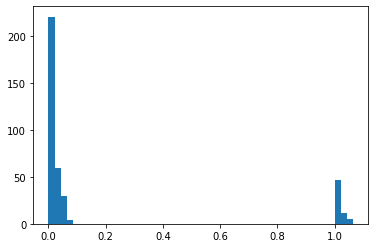

In [41]:
plt.hist(distances, bins=50)
plt.show()

### 1.2. Genetic Algorithm

In [10]:
dice_df = pd.DataFrame(x_train)
dice_df.columns = feature_names
dice_df['status'] = y_train

feature_names_cont = ['loan_amnt', 'annual_inc', 'dti',
                     'earliest_cr_line', 'open_acc', 'revol_bal', 'revol_util',
                     'total_acc', 'fico_score']
for c in feature_names_cont:
    dice_df[c] = dice_df[c].astype(float)

dice_data = dice_ml.Data(
    dataframe=dice_df,
    continuous_features=feature_names_cont,
    outcome_name='status'
)

dice_model = dice_ml.Model(model=ebm, backend='sklearn')

In [11]:
exp = dice_ml.Dice(dice_data, dice_model, method='genetic')

dice_rejected_df = explain_df.copy()
for c in feature_names_cont:
    dice_rejected_df[c] = dice_rejected_df[c].astype(float)

explanation_generic = exp.generate_counterfactuals(
    dice_rejected_df,
    total_CFs=1,
    features_to_vary=features_to_vary,
    # posthoc_sparsity_param=0.2,
    verbose=False,
    desired_class="opposite")

100%|██████████| 378/378 [01:43<00:00,  3.65it/s]


In [14]:
g_distances, g_feature_nums, g_failed_indexes = [], [], []

for i in range(len(explanation_generic.cf_examples_list)):
    if explanation_generic.cf_examples_list[i].final_cfs_df is None:
        g_failed_indexes.append(i)
        continue

    x1 = dice_rejected_df.iloc[i, :]
    x2 = explanation_generic.cf_examples_list[i].final_cfs_df.iloc[0, :]

    cur_distance, changed_feature = evaluate_cf(x1, x2, feature_names, my_coach.cont_mads)
    
    g_distances.append(cur_distance)
    g_feature_nums.append(changed_feature)


In [15]:
print(
    "generic",
    "\ndistance: ",
    np.mean(g_distances),
    "\nnum: ",
    np.mean(g_feature_nums),
    "\nfails: ",
    len(g_failed_indexes),
)


generic 
distance:  3.1950324578332685 
num:  10.251989389920425 
fails:  1


### KD Tree

In [11]:
exp = dice_ml.Dice(dice_data, dice_model, method='kdtree')

dice_rejected_df = explain_df.copy()
for c in feature_names_cont:
    dice_rejected_df[c] = dice_rejected_df[c].astype(float)

explanation_tree = exp.generate_counterfactuals(
    dice_rejected_df,
    total_CFs=1,
    features_to_vary=features_to_vary,
    # posthoc_sparsity_param=0.2,
    verbose=False,
    desired_class="opposite")

  6%|▌         | 22/378 [02:46<44:58,  7.58s/it]


KeyboardInterrupt: 

In [235]:
k_distances, k_feature_nums, k_failed_indexes = [], [], []

for i in range(len(explanation_tree.cf_examples_list)):
    if explanation_tree.cf_examples_list[i].final_cfs_df is None:
        k_failed_indexes.append(i)
        continue

    if explanation_tree.cf_examples_list[i].final_cfs_df.shape == (0, 0):
        k_failed_indexes.append(i)
        continue

    x1 = dice_rejected_df.iloc[i, :]
    x2 = explanation_tree.cf_examples_list[i].final_cfs_df.iloc[0, :]

    cur_distance, changed_feature = evaluate_cf(x1, x2, feature_names, my_coach.cont_mads)
    
    k_distances.append(cur_distance)
    k_feature_nums.append(changed_feature)


In [236]:
print(
    "tree",
    "\ndistance: ",
    np.mean(k_distances),
    "\nnum: ",
    np.mean(k_feature_nums),
    "\nfails: ",
    len(k_failed_indexes),
)


tree 
distance:  3.537431334905131 
num:  9.957446808510639 
fails:  331


### Random

In [161]:
exp = dice_ml.Dice(dice_data, dice_model, method='random')

dice_rejected_df = explain_df.copy()
for c in feature_names_cont:
    dice_rejected_df[c] = dice_rejected_df[c].astype(float)

explanation_random = exp.generate_counterfactuals(
    dice_rejected_df,
    total_CFs=1,
    features_to_vary=features_to_vary,
    # posthoc_sparsity_param=0.2,
    verbose=False,
    desired_class="opposite")

 37%|███▋      | 139/378 [54:49<1:34:15, 23.66s/it] 


KeyboardInterrupt: 

In [ ]:
r_distances, r_feature_nums, r_failed_indexes = [], [], []

for i in range(len(explanation_random.cf_examples_list)):
    if explanation_random.cf_examples_list[i].final_cfs_df is None:
        r_failed_indexes.append(i)
        continue

    x1 = dice_rejected_df.iloc[i, :]
    x2 = explanation_random.cf_examples_list[i].final_cfs_df.iloc[0, :]

    cur_distance, changed_feature = evaluate_cf(x1, x2, feature_names, my_coach.cont_mads)
    
    r_distances.append(cur_distance)
    r_feature_nums.append(changed_feature)
